In [1]:
import torch
import random
import os
import time
import torchvision
import copy
import json
import cv2
import shutil

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.nn import functional as F
from torchvision import datasets, transforms
from skimage import io, color, morphology, exposure
from torch.utils import data
from PIL import Image
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import decomposition, manifold
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.utils import hms_string
from sklearn.cluster import KMeans
from helperfns import visualization
from concurrent.futures import ProcessPoolExecutor


from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
import seaborn as sns
import pathlib
import matplotlib as mpl
import statistics as stat


torch.__version__

'2.2.2'

In [2]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [22]:
original_dataset = 'lemon_dataset'

new_dataset = "dataset"
roi_dataset = 'roi_dataset'

if not os.path.exists(roi_dataset):
  os.mkdir(roi_dataset)
if not os.path.exists(new_dataset):
  os.mkdir(new_dataset)


# train new dataset
if not os.path.exists(os.path.join(new_dataset, 'train')):
  os.makedirs(os.path.join(new_dataset, 'train/bad'))
  os.makedirs(os.path.join(new_dataset, 'train/empty'))
  os.makedirs(os.path.join(new_dataset, 'train/good'))

# test new dataset
if not os.path.exists(os.path.join(new_dataset, 'test')):
  os.makedirs(os.path.join(new_dataset, 'test/bad'))
  os.makedirs(os.path.join(new_dataset, 'test/empty'))
  os.makedirs(os.path.join(new_dataset, 'test/good'))


# train roi dataset
if not os.path.exists(os.path.join(roi_dataset, 'train')):
  os.makedirs(os.path.join(roi_dataset, 'train/bad'))
  os.makedirs(os.path.join(roi_dataset, 'train/empty'))
  os.makedirs(os.path.join(roi_dataset, 'train/good'))

# test roi dataset
if not os.path.exists(os.path.join(roi_dataset, 'test')):
  os.makedirs(os.path.join(roi_dataset, 'test/bad'))
  os.makedirs(os.path.join(roi_dataset, 'test/empty'))
  os.makedirs(os.path.join(roi_dataset, 'test/good'))


print("Done!!")

Done!!


In [4]:
test_size = .2

test_bad_size = int(len(os.listdir(os.path.join(original_dataset, 'bad_quality'))) * test_size)
test_good_size = int(len(os.listdir(os.path.join(original_dataset, 'good_quality'))) * test_size)
test_empty_size = int(len(os.listdir(os.path.join(original_dataset, 'empty_background'))) * test_size)

test_empty_size, test_good_size, test_bad_size

NameError: name 'original_dataset' is not defined

In [ ]:
# test
for bad in os.listdir(os.path.join(original_dataset, 'bad_quality'))[:test_bad_size]:
    src = os.path.join(original_dataset, 'bad_quality', bad)
    dest = os.path.join(new_dataset, 'test/bad')
    shutil.move(src, dest)

for good in os.listdir(os.path.join(original_dataset, 'good_quality'))[:test_good_size]:
    src = os.path.join(original_dataset, 'good_quality', good)
    dest = os.path.join(new_dataset, 'test/good')
    shutil.move(src, dest)

for empty in os.listdir(os.path.join(original_dataset, 'empty_background'))[:test_empty_size]:
    src = os.path.join(original_dataset, 'empty_background', empty)
    dest = os.path.join(new_dataset, 'test/empty')
    shutil.move(src, dest)
    
# train
for bad in os.listdir(os.path.join(original_dataset, 'bad_quality')):
    src = os.path.join(original_dataset, 'bad_quality', bad)
    dest = os.path.join(new_dataset, 'train/bad')
    shutil.move(src, dest)

for good in os.listdir(os.path.join(original_dataset, 'good_quality')):
    src = os.path.join(original_dataset, 'good_quality', good)
    dest = os.path.join(new_dataset, 'train/good')
    shutil.move(src, dest)

for empty in os.listdir(os.path.join(original_dataset, 'empty_background')):
    src = os.path.join(original_dataset, 'empty_background', empty)
    dest = os.path.join(new_dataset, 'train/empty')
    shutil.move(src, dest)

print("Done!")

In [25]:
def cluster_image(labels, RGB):
  BW = np.ones(RGB.shape)
  R,C,o = RGB.shape
  labels = labels.reshape(R,C)
  x,y = labels.shape
  center_cluster = labels[x//2-x//6:x//2+x//6,y//2-y//6:y//2+y//6]
  labels=labels.reshape((R,C))
  c = stat.mode(center_cluster.reshape(-1).tolist())
  for i in range(R):
      for j in range(C):
          if labels[i,j] == c :
              BW[i,j,0] = RGB[i,j,0]
              BW[i,j,1] = RGB[i,j,1]
              BW[i,j,2] = RGB[i,j,2]
          else:
              BW[i,j] = [255,255,255]

  BW = BW.astype('uint8')
  return BW, labels

In [26]:
def Kmeans(feature_image, cols):
  kmeans = KMeans(n_clusters=2, random_state=SEED, n_init='auto')
  labels = kmeans.fit_predict(feature_image)
  kmeans_segmented = labels.reshape(rows, cols)
  return labels

In [5]:
# train
train_bad = ["./dataset/train/bad/"+i for i in os.listdir("./dataset/train/bad/")]
train_good = ["./dataset/train/good/"+i for i in os.listdir("./dataset/train/good/")]
train_empty = ["./dataset/train/empty/"+i for i in os.listdir("./dataset/train/empty/")]

# test

test_bad = ["./dataset/test/bad/"+i for i in os.listdir("./dataset/test/bad/")]
test_good = ["./dataset/test/good/"+i for i in os.listdir("./dataset/test/good/")]
test_empty = ["./dataset/test/empty/"+i for i in os.listdir("./dataset/test/empty/")]

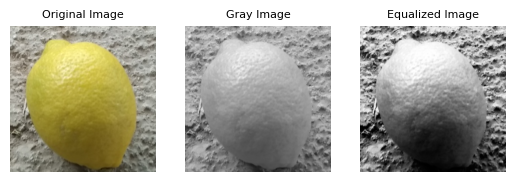

In [22]:

# fgbg = cv2.createBackgroundSubtractorMOG2()

# fgmask = fgbg.apply(cv2.imread(test_good[1]))

# plt.imshow(cv2.cvtColor(fgmask, cv2.COLOR_BGR2RGB))
# # plt.imshow(cv2.imread(test_good[0]))|


original = cv2.imread(train_good[0])
gray_image = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
equalized_image = cv2.equalizeHist(gray_image)



plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=8)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
plt.title("Gray Image", fontsize=8)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
plt.title("Equalized Image", fontsize=8)
plt.axis("off")
plt.show()


smoothed_image = cv2.GaussianBlur(original, (5, 5), 0)
edges = cv2.Canny(original, threshold1=100, threshold2=200)


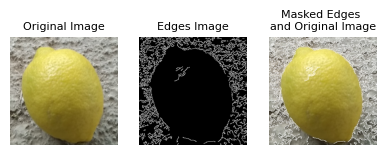

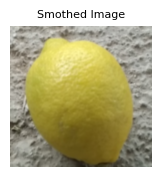

In [92]:
smoothed_image = cv2.GaussianBlur(original, (5, 5), 0)
edges = cv2.Canny(original, threshold1=100, threshold2=200)
mask_1 = cv2.bitwise_or(original, cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
mask_2 = cv2.bitwise_or(smoothed_image, cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=8)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.title("Edges Image", fontsize=8)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(mask_1, cv2.COLOR_BGR2RGB))
plt.title("Masked Edges \nand Original Image", fontsize=8)
plt.axis("off")
plt.show()

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2RGB))
plt.title("Smothed Image", fontsize=8)
plt.axis("off")

plt.tight_layout() 
plt.show()


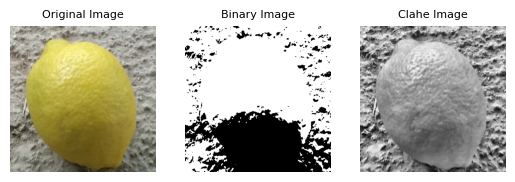

In [38]:
_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(gray_image)


plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=8)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
plt.title("Binary Image", fontsize=8)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))
plt.title("Clahe Image", fontsize=8)
plt.axis("off")
plt.show()

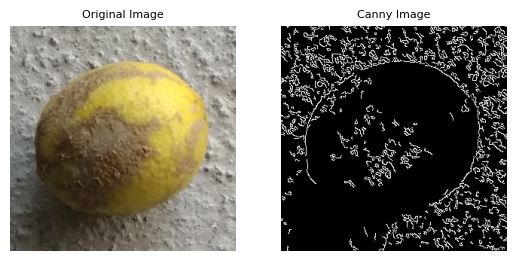

In [68]:

class CannyEdgeDetection:
    def detect_edges(image, bg=(0, 0, 0), display=False):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib
        edges = cv2.Canny(image, threshold1=100, threshold2=200)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        if display:
            # Display the result
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title("Original Image", fontsize=8)
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
            plt.title("Canny Image", fontsize=8)
            plt.axis("off")
        return edges
        
    def __call__(self, image):
        img = CannyEdgeDetection.detect_edges(image)
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        return img

_ = CannyEdgeDetection.detect_edges(Image.open(test_bad[0]), display=True)

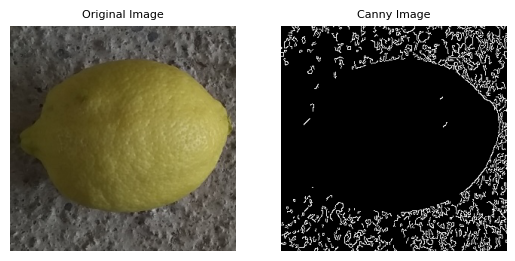

In [35]:
_ = CannyEdgeDetection.detect_edges(Image.open(test_good[0]), display=True)

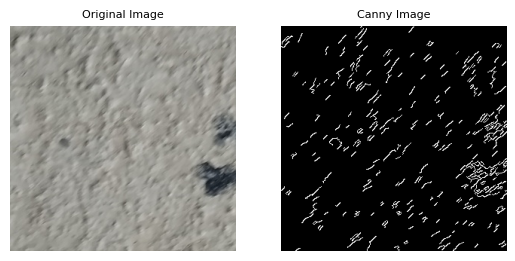

In [44]:
_ = CannyEdgeDetection.detect_edges(Image.open(test_empty[0]), display=True)

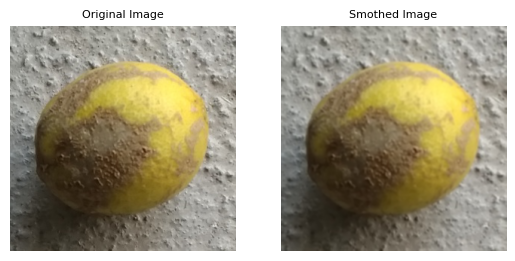

In [66]:

class GaussianBlurSmoothing:
    def smoothing(image, bg=(0, 0, 0), display=False):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib
        smoothed_image = cv2.GaussianBlur(image, (3, 3), 12)
        smoothed_image = cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2RGB)
        if display:
            # Display the result
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title("Original Image", fontsize=8)
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(smoothed_image)
            plt.title("Smothed Image", fontsize=8)
            plt.axis("off")
        return smoothed_image
        
    def __call__(self, image):
        img = GaussianBlurSmoothing.smoothing(image)
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        return img

_ = GaussianBlurSmoothing.smoothing(Image.open(test_bad[0]), display=True)

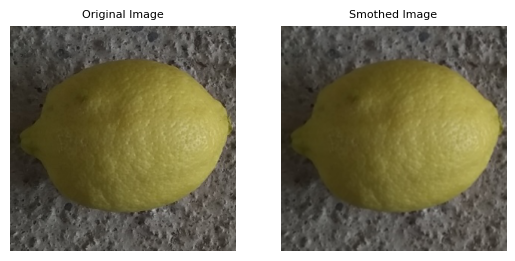

In [63]:
_ = GaussianBlurSmoothing.smoothing(Image.open(test_good[0]), display=True)

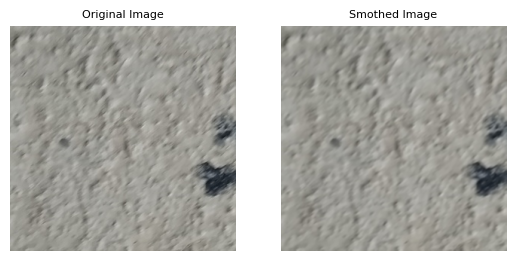

In [64]:
_ = GaussianBlurSmoothing.smoothing(Image.open(test_empty[0]), display=True)

In [95]:
class BackgroundIsolation:
    def remove_bg(image, bg=(0, 0, 0), display=False):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib
        # Convert the image to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # Increase the brightness by scaling up the Value (V) channel
        value_increase = 50  # Adjust this value as needed
        hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] + value_increase, 0, 255)

        # Convert back to BGR color space to proceed with yellow color segmentation
        bright_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

        # Convert the brightened image back to HSV for color segmentation
        hsv_image_bright = cv2.cvtColor(bright_image, cv2.COLOR_BGR2HSV)
        # Define color range for the lemon (yellow range)
        lower_yellow = np.array([20, 100, 100])  # Lower range for yellow
        upper_yellow = np.array([40, 255, 255])  # Upper range for yellow

        # Create a mask for the yellow color
        mask = cv2.inRange(hsv_image_bright, lower_yellow, upper_yellow)

        # Refine the mask using morphological operations to remove small noise
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        # Use the mask to extract the lemon and set the background
        segmented_image = np.copy(image_rgb)
        segmented_image[mask == 0] = bg
        if display:
            # Display the result
            plt.subplot(1, 3, 1)
            plt.imshow(image_rgb)
            plt.title("Original Image", fontsize=8)
            plt.axis("off")
        
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
            plt.title("Brightened Image", fontsize=8)
            plt.axis("off")
        
            plt.subplot(1, 3, 3)
            plt.imshow(segmented_image)
            plt.title("Isolated with Background", fontsize=8)
            plt.axis("off")
            plt.show()
        return segmented_image
        
    def __call__(self, image):
        img = BackgroundIsolation.remove_bg(image)
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        plt.imshow(img)
        return img
        

In [100]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image
    

In [62]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
            transforms.Resize(pretrained_size),
            GaussianBlurSmoothing(),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean = pretrained_means,
                                std = pretrained_stds)
])


img = train_transforms(Image.open(train_good[0]))

plt.imshow(normalize_image(img).permute(1, 2, 0).cpu().numpy())

NameError: name 'normalize_image' is not defined

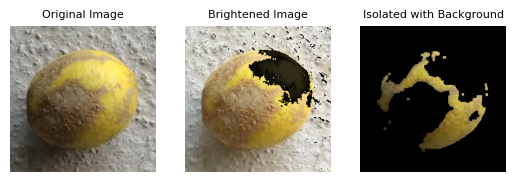

In [91]:
_ = BackgroundIsolation.remove_bg(Image.open(test_bad[0]), display=True)

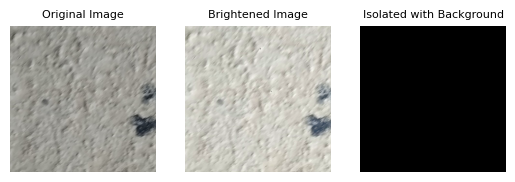

In [75]:
_ = BackgroundIsolation.remove_bg(Image.open(test_empty[0]), display=True)

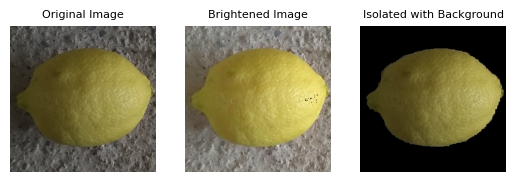

In [76]:
_ = BackgroundIsolation.remove_bg(Image.open(test_good[0]), display=True)

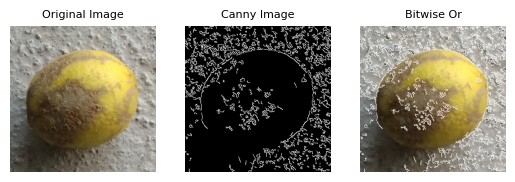

In [98]:


class CannyEdgeDetectionAndNoiseReduction:
    def detect_edges(image, bg=(0, 0, 0), display=False):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib
        edges = cv2.Canny(image, threshold1=100, threshold2=200)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        masked = cv2.bitwise_or(image, edges)
        if display:
            # Display the result
            plt.subplot(1, 3, 1)
            plt.imshow(image_rgb)
            plt.title("Original Image", fontsize=8)
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
            plt.title("Canny Image", fontsize=8)
            plt.axis("off")
            
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
            plt.title("Bitwise Or", fontsize=8)
            plt.axis("off")
        return masked
        
    def __call__(self, image):
        img = CannyEdgeDetectionAndNoiseReduction.detect_edges(image)
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        return img

_ = CannyEdgeDetectionAndNoiseReduction.detect_edges(Image.open(test_bad[0]), display=True)

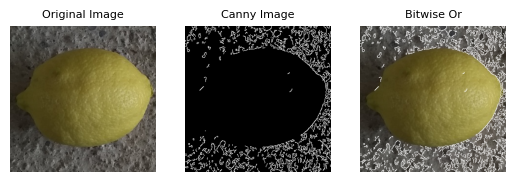

In [99]:
_ = CannyEdgeDetectionAndNoiseReduction.detect_edges(Image.open(test_good[0]), display=True)

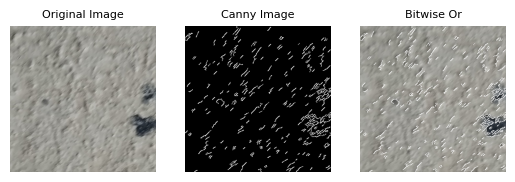

In [100]:
_ = CannyEdgeDetectionAndNoiseReduction.detect_edges(Image.open(test_empty[0]), display=True)